## Classification

Datasets used :
- PoetryFoundationData.csv
- Poem_classification
- topics folder

Might be complicated to merge these datasets cause first one is multi label, second one contains 4 very large classes, and last one more than 100 very specific classes.

For multiclass classification, **Poem_classification** and **topics folder**:
- study data
- treatment to apply : remove \n ? remove punctuation ? remove poems with length < n ? lemmatization ?
- tokenizer : train own ? nltk ?
- embedding : countvectorizer ? tf-idf ? gensim ? word2vec ? own features ?
- Logistic Regression (might test other multiclass models)

For multilabel classification, **PoetryFoundationData.csv**:
- same as before
- vectorize labels
- https://www.linkedin.com/pulse/algorithms-multiclass-classification-amir-hossein-takbiri/

In [1]:
import pandas as pd
import numpy as np
import os
import string
import matplotlib.pyplot as plt
import statistics
import gensim

from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

In [79]:
df = pd.read_csv("../our_data/final_lemm.csv") # final csv with removal of 'like', 'one', 'us'

In [3]:
classes = np.unique(df["topic"], return_counts=True)
print(f"Number of classes : {len(classes[1])}\n")
for i in range(len(classes[0])):
    print(f"{classes[0][i]} : {classes[1][i]} samples")

Number of classes : 5

arts&sciences : 2170 samples
love : 2080 samples
nature : 2422 samples
relationships : 1804 samples
religion : 1561 samples


### Data analysis

In [4]:
text_df = pd.DataFrame(df["topic"])
text_df['len'] = df["poem"].apply(len)
print("Mean length of poems (in characters) : ", int(text_df['len'].mean()))
print("Min length of poems (in characters) : ", text_df['len'].min())
print("Max length of poems (in characters) : ", text_df['len'].max())

Mean length of poems (in characters) :  1010
Min length of poems (in characters) :  22
Max length of poems (in characters) :  91380


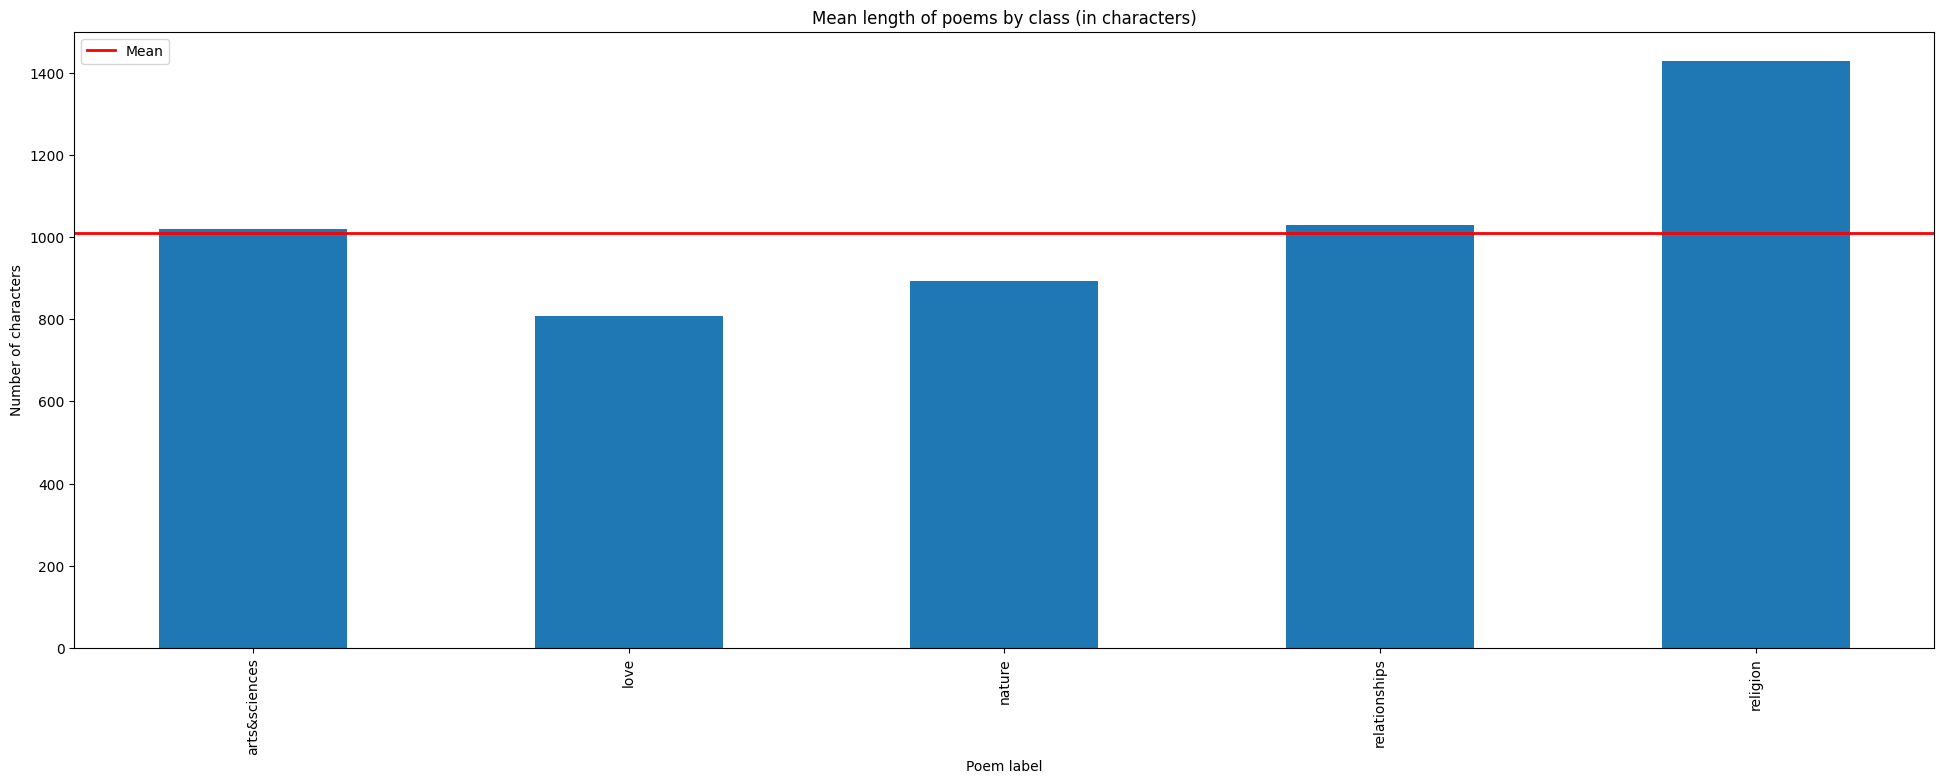

In [5]:
df_mean_length = text_df.groupby('topic').mean().reset_index()

plt.figure(figsize=(24, 8))
plt.bar(x=df_mean_length["topic"], height=df_mean_length["len"], width=0.5)

plt.xlabel('Poem label')
plt.ylabel('Number of characters')
plt.title('Mean length of poems by class (in characters)')
plt.axhline(y=int(text_df['len'].mean()), color='r', linestyle='-', linewidth=2, label='Mean')
plt.legend()

plt.xticks(rotation=90)

plt.show()

Since almost all classes have poems of same length, it won't be an useful feature to use.

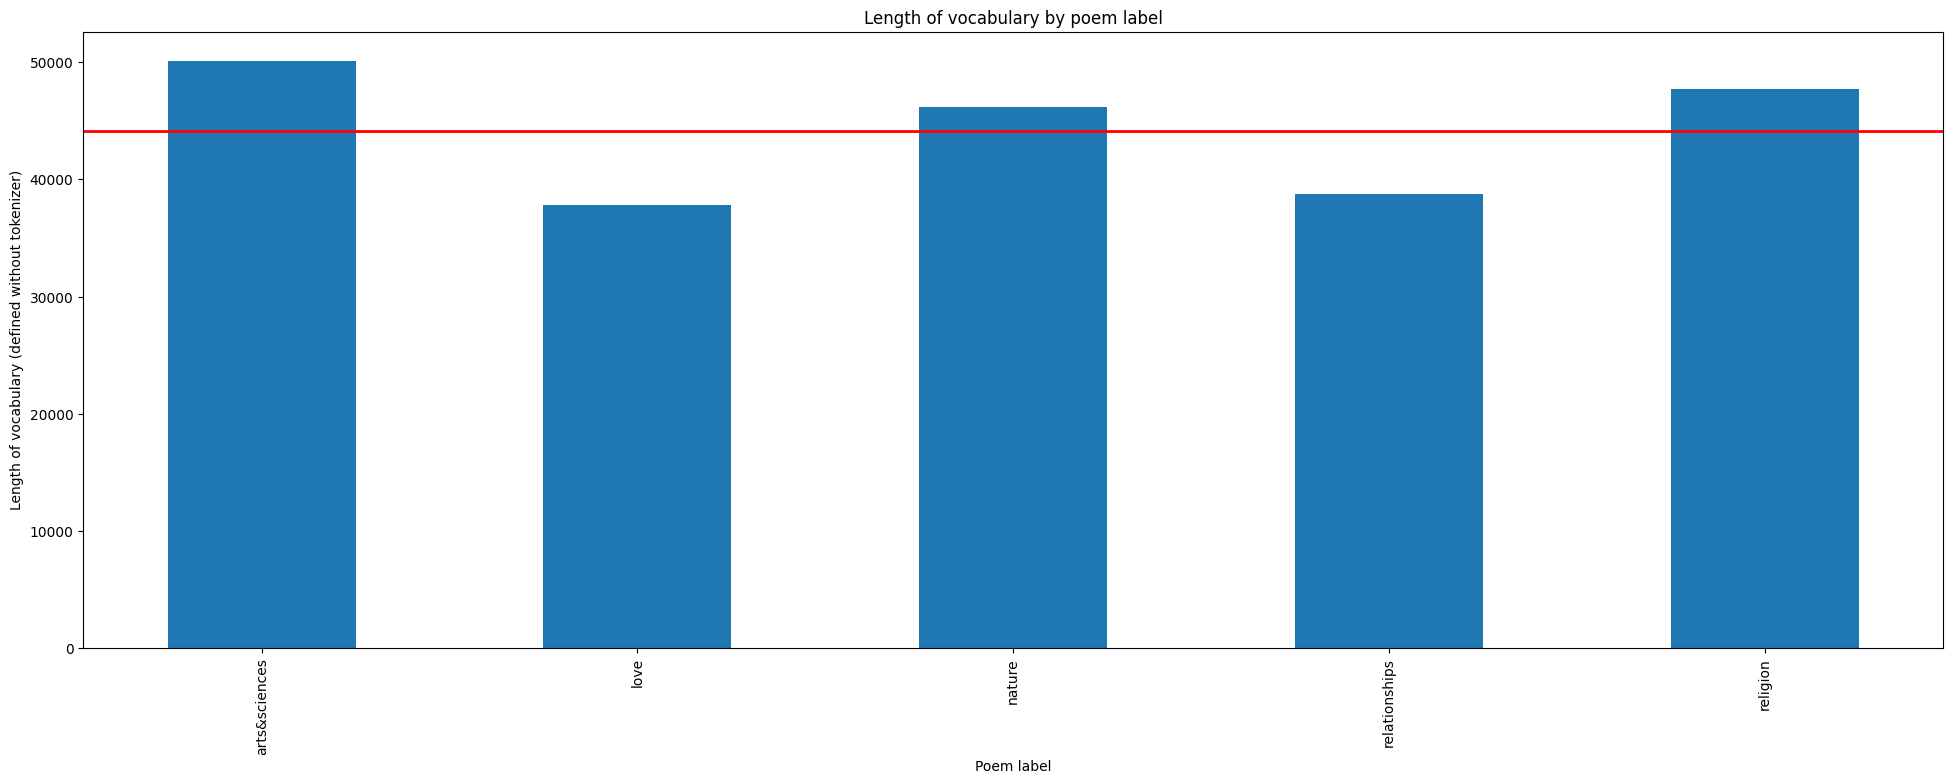

In [6]:
vocab_length_by_label = []
most_occuring_words_by_label = []
labels = np.unique(df["topic"])
for label in labels:
    voc_tmp = " ".join(list(df[df["topic"] == label]["poem"])).split()
    vocab_length_by_label.append(len(set(voc_tmp)))
    u, count = np.unique(voc_tmp, return_counts=True)
    count_sort_ind = np.argsort(-count)
    most_occuring_words_by_label.append((u[count_sort_ind][:5], count[count_sort_ind][:5]))

plt.figure(figsize=(24, 8))
plt.bar(x=labels, height=vocab_length_by_label, width=0.5)
plt.xlabel('Poem label')
plt.ylabel('Length of vocabulary (defined without tokenizer)')
plt.title('Length of vocabulary by poem label')

plt.axhline(y=statistics.mean(vocab_length_by_label), color='r', linestyle='-', linewidth=2, label='Mean')
plt.xticks(rotation=90)

plt.show()

In [7]:
for i in range(len(labels)):
    print(f"{labels[i]} : ", end="")
    tmp = most_occuring_words_by_label[i]
    for i in range(5):
        print(f"{tmp[1][i]} occurence(s) of {tmp[0][i]}", end=", ")
    print()
    

arts&sciences : 981 occurence(s) of would, 908 occurence(s) of know, 896 occurence(s) of time, 834 occurence(s) of see, 815 occurence(s) of say, 
love : 2373 occurence(s) of love, 876 occurence(s) of would, 811 occurence(s) of know, 777 occurence(s) of never, 769 occurence(s) of thy, 
nature : 952 occurence(s) of light, 929 occurence(s) of back, 884 occurence(s) of see, 850 occurence(s) of water, 843 occurence(s) of time, 
relationships : 1044 occurence(s) of back, 962 occurence(s) of time, 936 occurence(s) of would, 888 occurence(s) of know, 860 occurence(s) of say, 
religion : 1672 occurence(s) of god, 1366 occurence(s) of thy, 1031 occurence(s) of thou, 1025 occurence(s) of man, 947 occurence(s) of love, 


As we can see, there is a lot of diversity in the most used words for each category, so a CountVectorizer might be a good start for embedding.

## Logistic Regression

### CountVectorizer

In [8]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['poem'])

In [9]:
y = df['topic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model = LogisticRegression(multi_class="multinomial", max_iter=1000, random_state=42, solver='saga')
model.fit(X_train, y_train)

c:\Users\mael\Desktop\workspace\NLP1_Project\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42,
                   solver='saga')

In [11]:
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Classification Report:
               precision    recall  f1-score   support

arts&sciences     0.4904    0.4680    0.4790       438
         love     0.5245    0.6000    0.5597       410
       nature     0.5166    0.5970    0.5539       469
relationships     0.4543    0.3934    0.4217       366
     religion     0.5687    0.4585    0.5077       325

     accuracy                         0.5100      2008
    macro avg     0.5109    0.5034    0.5044      2008
 weighted avg     0.5096    0.5100    0.5072      2008



Very bad result, might try with lemmatization.

In [12]:
lemmatizer = WordNetLemmatizer()
df["poem"] = df["poem"].apply(lambda poem: " ".join([lemmatizer.lemmatize(word) for word in poem.split()]))

In [13]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['poem'])

In [14]:
y = df['topic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
model = LogisticRegression(multi_class="multinomial", max_iter=1000, random_state=42, solver='saga')
model.fit(X_train, y_train)

c:\Users\mael\Desktop\workspace\NLP1_Project\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42,
                   solver='saga')

In [16]:
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Classification Report:
               precision    recall  f1-score   support

arts&sciences     0.5095    0.4909    0.5000       438
         love     0.5097    0.5756    0.5407       410
       nature     0.5312    0.5991    0.5631       469
relationships     0.4671    0.4071    0.4350       366
     religion     0.5673    0.4800    0.5200       325

     accuracy                         0.5164      2008
    macro avg     0.5169    0.5105    0.5118      2008
 weighted avg     0.5162    0.5164    0.5144      2008



In [17]:
X = df['poem']
y = df['topic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
model = make_pipeline(CountVectorizer(tokenizer=word_tokenize), LogisticRegression(max_iter=1000, random_state=42, multi_class="multinomial", solver='saga'))
model.fit(X_train, y_train)

c:\Users\mael\Desktop\workspace\NLP1_Project\.venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\mael\Desktop\workspace\NLP1_Project\.venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(tokenizer=<function word_tokenize at 0x000001B5BF3663B0>)),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    random_state=42, solver='saga'))])

In [19]:
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Classification Report:
               precision    recall  f1-score   support

arts&sciences     0.5097    0.4795    0.4941       438
         love     0.5064    0.5780    0.5399       410
       nature     0.5291    0.6013    0.5629       469
relationships     0.4704    0.4126    0.4396       366
     religion     0.5657    0.4769    0.5175       325

     accuracy                         0.5154      2008
    macro avg     0.5163    0.5097    0.5108      2008
 weighted avg     0.5155    0.5154    0.5134      2008



### tf-idf

In [98]:
X = df['poem']
y = df['topic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
model = make_pipeline(TfidfVectorizer(), LogisticRegression(multi_class="multinomial", max_iter=500, solver="saga", random_state=42, C=1.1))
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(C=1.1, max_iter=500,
                                    multi_class='multinomial', random_state=42,
                                    solver='saga'))])

In [118]:
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Classification Report:
               precision    recall  f1-score   support

arts&sciences     0.5083    0.5594    0.5326       438
         love     0.5721    0.5610    0.5665       410
       nature     0.5048    0.6695    0.5756       469
relationships     0.5124    0.3962    0.4468       366
     religion     0.6530    0.4400    0.5257       325

     accuracy                         0.5364      2008
    macro avg     0.5501    0.5252    0.5295      2008
 weighted avg     0.5447    0.5364    0.5328      2008



### word2vec

In [59]:
import gensim.downloader

word2vec = gensim.downloader.load('word2vec-google-news-300')

In [83]:
def transform_X(serie: pd.Series):
    tmp = [np.mean(np.array([word2vec[word] for word in poem.split() if word in word2vec]), axis=0) for poem in serie]
    cleaned = []
    ind = []
    i = 0
    for e in tmp:
        if e.shape != ():
            cleaned.append(e)
        else:
            ind.append(i)
        i += 1
    return np.array(cleaned), ind

X_w2v, ind = transform_X(df["poem"])

In [84]:
y = df['topic']

X_train, X_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

In [95]:
model = LogisticRegression(multi_class="multinomial", max_iter=1000, solver="saga", random_state=42, C=2)
model.fit(X_train, y_train)

LogisticRegression(C=2, max_iter=1000, multi_class='multinomial',
                   random_state=42, solver='saga')

In [96]:
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Classification Report:
               precision    recall  f1-score   support

arts&sciences     0.5159    0.5571    0.5357       438
         love     0.5433    0.5512    0.5472       410
       nature     0.5386    0.6397    0.5848       469
relationships     0.5316    0.4372    0.4798       366
     religion     0.5709    0.4585    0.5085       325

     accuracy                         0.5374      2008
    macro avg     0.5400    0.5287    0.5312      2008
 weighted avg     0.5385    0.5374    0.5349      2008



### With own word2vec

In [3]:
X = df['poem']
y = df['topic']

In [29]:
L = []
for v in X:
    L.append(v.split())

In [30]:
word2vec = Word2Vec(sentences=L, vector_size=500, min_count=1, workers=4)

In [31]:
def transform_X(serie: pd.Series):
    return np.array([np.mean(np.array([word2vec.wv[word] for word in poem.split() if word in word2vec.wv]), axis=0) for poem in serie])

X_w2v = transform_X(df["poem"])
X_train, X_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

In [32]:
model = LogisticRegression(multi_class="multinomial", max_iter=1000, solver="saga", random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42,
                   solver='saga')

In [33]:
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Classification Report:
               precision    recall  f1-score   support

arts&sciences     0.4076    0.4886    0.4444       438
         love     0.5110    0.4537    0.4806       410
       nature     0.4642    0.6226    0.5319       469
relationships     0.4837    0.4044    0.4405       366
     religion     0.5326    0.3015    0.3851       325

     accuracy                         0.4671      2008
    macro avg     0.4798    0.4542    0.4565      2008
 weighted avg     0.4760    0.4671    0.4619      2008



## Naive Bayes

In [54]:
X = df['poem']
y = df['topic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Countvectorizer

In [55]:
model = make_pipeline(CountVectorizer(), MultinomialNB(alpha=0.08))
model.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB(alpha=0.08))])

In [56]:
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Classification Report:
               precision    recall  f1-score   support

arts&sciences     0.4358    0.3721    0.4015       438
         love     0.4834    0.3561    0.4101       410
       nature     0.4794    0.5693    0.5205       469
relationships     0.3635    0.4945    0.4190       366
     religion     0.4007    0.3415    0.3688       325

     accuracy                         0.4323      2008
    macro avg     0.4326    0.4267    0.4240      2008
 weighted avg     0.4368    0.4323    0.4289      2008



### Tf-idf

In [57]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha=0.05))
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB(alpha=0.05))])

In [58]:
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Classification Report:
               precision    recall  f1-score   support

arts&sciences     0.4410    0.4178    0.4291       438
         love     0.4932    0.4390    0.4645       410
       nature     0.4436    0.6546    0.5289       469
relationships     0.3921    0.4071    0.3995       366
     religion     0.6026    0.2892    0.3909       325

     accuracy                         0.4547      2008
    macro avg     0.4745    0.4416    0.4426      2008
 weighted avg     0.4695    0.4547    0.4480      2008



In [41]:
df.to_csv("final_lemm.csv")